In [9]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms
from torch.nn import functional as F
import os
import sys
from tqdm import tqdm
import numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import requests

# Download the required files.

def download_file(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful.
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")


In [3]:
 # hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

def load_labels(data_dir='../../data/external/Places365'):
    # Create a data directory (if it does not exist).
    os.makedirs(data_dir, exist_ok=True)

    # scene category relevant
    file_name_category = os.path.join(data_dir, 'categories_places365.txt')
    if not os.path.exists(file_name_category):
        print(f"{file_name_category} does not exist. Downloading...")
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        download_file(synset_url, file_name_category)
    classes = list()
    try:
        with open(file_name_category) as class_file:
            for line in class_file:
                classes.append(line.strip().split(' ')[0][3:])
        classes = tuple(classes)
    except Exception as e:
        print(f"Error reading {file_name_category}: {e}")

    # indoor and outdoor relevant
    file_name_IO = os.path.join(data_dir, 'IO_places365.txt')
    if not os.path.exists(file_name_IO):
        print(f"{file_name_IO} does not exist. Downloading...")
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        download_file(synset_url, file_name_IO)
    try:
        with open(file_name_IO) as f:
            lines = f.readlines()
            labels_IO = []
            for line in lines:
                items = line.rstrip().split()
                labels_IO.append(int(items[-1]) - 1)  # 0 is indoor, 1 is outdoor
        labels_IO = np.array(labels_IO)
    except Exception as e:
        print(f"Error reading {file_name_IO}: {e}")

    # scene attribute relevant
    file_name_attribute = os.path.join(data_dir, 'labels_sunattribute.txt')
    if not os.path.exists(file_name_attribute):
        print(f"{file_name_attribute} does not exist. Downloading...")
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        download_file(synset_url, file_name_attribute)
    try:
        with open(file_name_attribute) as f:
            lines = f.readlines()
            labels_attribute = [item.rstrip() for item in lines]
    except Exception as e:
        print(f"Error reading {file_name_attribute}: {e}")

    file_name_W = os.path.join(data_dir, 'W_sceneattribute_wideresnet18.npy')
    if not os.path.exists(file_name_W):
        print(f"{file_name_W} does not exist. Downloading...")
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        download_file(synset_url, file_name_W)
    try:
        W_attribute = np.load(file_name_W)
    except Exception as e:
        print(f"Error reading {file_name_W}: {e}")
        W_attribute = None

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnTF():
# load the image transformer
    tf = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])
    return tf

def load_model(model_dir='../../data/external/Places365/model'):
    # Create a data directory (if it does not exist).
    os.makedirs(model_dir, exist_ok=True)

    model_file = os.path.join(model_dir, 'wideresnet18_places365.pth.tar')
    script_file = os.path.join(model_dir, 'wideresnet.py')

    # Download the model files.
    if not os.path.exists(model_file):
        print(f"{model_file} does not exist. Downloading...")
        model_url = 'http://places2.csail.mit.edu/models_places365/wideresnet18_places365.pth.tar'
        download_file(model_url, model_file)

    # Download the script files.
    if not os.path.exists(script_file):
        print(f"{script_file} does not exist. Downloading...")
        script_url = 'https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py'
        download_file(script_url, script_file)

    # Add the script files directory to the Python path.
    sys.path.append(model_dir)

    # Import the model.
    try:
        import wideresnet
        model = wideresnet.resnet18(num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
        state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)

        # Change the BatchNorm and avgpool layers.
        model = recursion_change_bn(model)
        model.avgpool = torch.nn.AvgPool2d(kernel_size=16, stride=1, padding=0)
        model.eval()

        # Set feature extraction hooks.
        features_names = ['layer4', 'avgpool']
        for name in features_names:
            model._modules.get(name).register_forward_hook(hook_feature)

        print("Model loaded successfully.")
        return model
    except ImportError as e:
        print(f"Error importing wideresnet module: {e}")
        return None

In [4]:
classes, labels_IO, labels_attribute, W_attribute = load_labels()

model = load_model()

tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

Model loaded successfully.


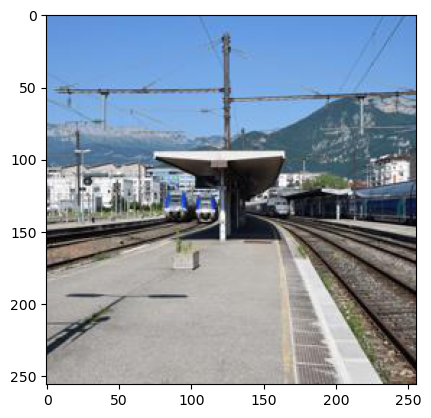

--SCENE CATEGORIES:
0.107 -> highway
0.076 -> promenade
0.073 -> industrial_area
--SCENE ATTRIBUTES:
man-made, open area, natural light, no horizon, far-away horizon, metal, sunny, transporting, driving


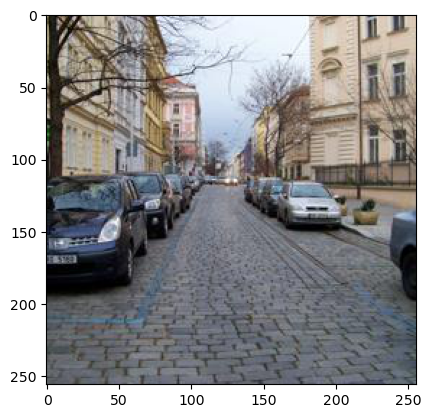

--SCENE CATEGORIES:
0.047 -> beach_house
0.032 -> slum
0.025 -> childs_room
--SCENE ATTRIBUTES:
man-made, no horizon, natural light, open area, enclosed area, metal, moist, vertical components, plastic


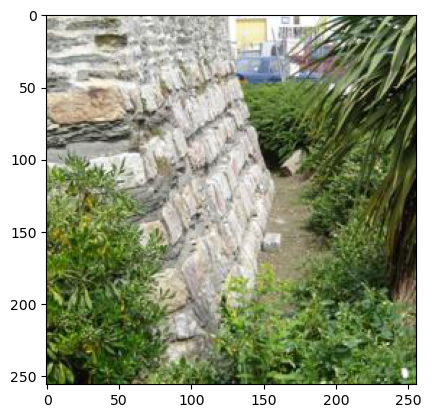

KeyboardInterrupt: 

In [13]:
# read data

data_path = '/home/ubuntu/landscape-aesthetics/data/processed/landscape_handmade/landscapes.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

data = pd.read_csv(data_path)
image_paths = data.iloc[:, 0]  
labels = data.iloc[:, 1]       

tf = returnTF()

for img_path, label in zip(image_paths, labels):
    test_image_path = image_folder / img_path
    img = Image.open(test_image_path)
    input_img = torch.autograd.Variable(tf(img).unsqueeze(0))
    plt.imshow(img)
    plt.show()
    # forward pass
    features_blobs = []
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    
    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    # output the prediction of scene category
    print('--SCENE CATEGORIES:')
    for i in range(0, 3):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    
    # output the scene attributes
    responses_attribute = W_attribute.dot(features_blobs[1])
    idx_a = np.argsort(responses_attribute)
    print('--SCENE ATTRIBUTES:')
    print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))